# Iteration 2 <br/>*Imputation and Cross Validation*

Jupyter Notebook referenced from my website:
[Software Nirvana: Cross Validation (2)](https://sdiehl28.netlify.com/2018/03/cross-validation-2/)

### Goals
1. Iteratively improve upon model using Age Imputation
2. Demonstrate the right and wrong way to perform Cross Validation
3. Compare this model with the previous iteration

### Where We Are
In the first iteration, we created a simple model and showed that the accuracy was better than the null model.  The null model is the model that predicts the predominant class in all cases.

### What's Next
<a href="https://en.wikipedia.org/wiki/Imputation_(statistics)">Imputation on Wikipedia</a>

This notebook will impute the missing values for Age and use Age as an additional attribute for prediction.  We will also check to see if adding the Age variable improved prediction accuracy.

Special attention will be paid to avoid a common beginner's mistake, which is to look at the test data when performing imputation or other preprocessing steps.  The easiest way to ensure there is no "test set leakage", is to use a Pipeline.

### Common Imports and Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

### Previous Model Building Iteration

In [2]:
# read in all the labeled data
all_data = pd.read_csv('../data/train.csv')

# break up the dataframe into X and y
X = all_data.drop('Survived', axis=1)
y = all_data['Survived']

# As before, remove all non-numeric fields and PassengerId
drop_fields = ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'PassengerId']
X = X.drop(drop_fields, axis=1)

X.dtypes

Pclass      int64
Age       float64
SibSp       int64
Parch       int64
Fare      float64
dtype: object

### Impute Age: Cross Validation the Right Way
This will be performed manually to emphasize how preprocessing operations work on the folds in a cross validation.  The key is that the held-out data, aka the test data, can never be looked at.

Later this will also be performed with an Imputer and a Pipeline to show a more concise workflow.

To a beginner, it can appear that using an Imputer and a Pipeline is a lot of extra work.  Why not just impute the Age before cross validation and be done with it.  If you were to look that at the ["Kernels"](https://www.kaggle.com/c/titanic/kernels?sortBy=votes&group=everyone&pageSize=20&competitionId=3136) on Kaggle posted for the Titantic dataset, you would see that most people do just that.  But this could lead to an estimate of model accuracy that is too high.  Looking at the test data prior to training your model is called "data leakage".

### Impute Age Manually (no Pipeline)
A nice introduction to overfitting, train/test split, and cross validation in Python is:[Train/Test Split and Cross Validation](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6)

K-Fold Cross Validation *is* train/test split, but performed K times to get a more accurate estimate of model accuracy.

We train the model on the train data and we test the accuracy of the model on the test data.

With a train/test split, we have missing Age values in both the train and test sets.  

For the train set, we replace the missing values with the average Age of the train set.  

For the test set, we are not permitted to look at its data as the purpose of the test set is for model evaluation.  If we look at its data, we have made the mistake of "data leakage".  The test data has "leaked" into our model building process.  This may cause our estimate of model accuracy to be too high.  For the test set, we replace the missing values with the average Age of the *train* set. 

All of the above holds true for Cross Validation as well, as Cross Validation is just multiple train/test splits.

For each of the K folds, we will compute the mean Age value in the train set, and use that value to replace the missing values in both the train and test sets.

In [3]:
# imports
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold

In [4]:
# Set random_state to get the same folds each time we call KFold()
random_state = 121212

# for illustration only, 5 or 10 is the recommended value
k_folds = 2

# prepare for cross validation
crossvalidation = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)

In [5]:
# use the K folds to impute Age and compute the accuracy score
my_scores = np.zeros(k_folds)
i = 0
lr_model = LogisticRegression()
for train_idx, test_idx in crossvalidation.split(X):
    # train subset
    X_train = X.iloc[train_idx, :].copy()
    y_train = y[train_idx].copy()
    
    # test subset
    X_test = X.iloc[test_idx, :].copy()
    y_test = y[test_idx].copy()
    
    # find the average age on the train set
    train_age_mean = X_train['Age'].mean()
    
    # use this value for *both* the train and test set
    X_train.loc[X_train['Age'].isnull(), 'Age'] = train_age_mean
    X_test.loc[X_test['Age'].isnull(), 'Age'] = train_age_mean # Key Concept!
    
    # fit model on train
    lr_model.fit(X_train, y_train)
    
    # predict using model on test
    predictions = lr_model.predict(X_test)
    
    # evaluate accuracy
    my_scores[i] = accuracy_score(y_test, predictions)
    i += 1

### Aside: Pandas copy
In the above, we had to use .copy() for our train and test sets.  This is critical to avoiding the Pandas warning: SettingWithCopyWarning.

The imputation requires us to modify both the train and test sets for X.  However X.iloc[] and X.loc[] both return a *view* into X, not a copy of a subset of X.  If we try to use this view to modify data, we will get: SettingwithCopyWarning.

In most cases this warning means your code will not do what you intended.  Therefore you should always write code that does not produce this Pandas warning.

It can be difficult to discover why this warning was issued.  One way to track this down is to print out the .is_copy member of your dataframe.  If you find you get this warning when trying to modify data through a view (implemented as a weak reference) then you need to get an independent copy of your data using .copy() and the warning will go away.

In [6]:
print(X.iloc[train_idx, :].is_copy) # view into dataframe
print(X.iloc[train_idx, :].copy().is_copy) # independent copy of dataframe

<weakref at 0x7f0c7ed42d68; to 'DataFrame' at 0x7f0c8192ee48>
None


### Impute Age with Pipeline
Scikit Learn correctly uses the mean of the train set as the replacement value for missing values in both the train and test sets.  However this is all done behind the scenes.  The following is exactly the same as the above, but requires much less code.

In [7]:
# Setup: same as above

# Set random_state to get the same folds each time we call KFold()
random_state = 121212

# for illustration only, 5 or 10 is the recommended value
k_folds = 2

# prepare for cross validation
crossvalidation = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)

In [8]:
# Use an Imputer and a Pipeline
# Note: Age is the only column in X with null values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='mean')

from sklearn.pipeline import make_pipeline
classifier = make_pipeline(imputer, LogisticRegression())

# cross_val_score() will properly compute 
# imputation and score per fold
scores = cross_val_score(classifier, X, y, cv=crossvalidation, 
                         scoring='accuracy', n_jobs=1)

# Check to see that we got the same scores 
# as in the above for-loop
print("Scores Match: ", (scores == my_scores).all())
print('Scores :', scores)
print(f'Cross Validated Accuracy: {scores.mean() :.3f}')

Scores Match:  True
Scores : [0.70852018 0.69438202]
Cross Validated Accuracy: 0.701


### Both Methods Produce the Same Result
The for-loop over each K fold train/test split is the same as using an Imputer and LogisticRegression in a Pipeline in cross_val_score().

### Impute Age: Cross Validation The Wrong Way
In my review of Kaggle Kernels published for the Titantic dataset most of the ["Kernels"](https://www.kaggle.com/c/titanic/kernels?sortBy=votes&group=everyone&pageSize=20&competitionId=3136) imputed the Age value over the entire data set, that is, they had "data leakage".

For imputation, "data leakage" usually doesn't impact the estimate of model accuracy enough to make a practical difference.  Nevertheless, it is bad practice and if you decide to impute missing values across your entire dataset, you should explicitly note it as well as why you expect it will make little difference.

In the following I will show that the approach to imputing missing values using the entire data set produces different results than the approach which avoids "data leakage" entirely.

In [9]:
# Prior to Cross Validation:
#   impute the missing values as the mean of *all* the data
# This is "data leakage"!
# Replace all null Age values with the mean of all Age Values
X.loc[X['Age'].isnull(), 'Age'] = X['Age'].mean()

# Setup: same as above
random_state = 121212
# for illustration only, 5 or 10 is the recommended value
n_splits = 2
crossvalidation = KFold(n_splits=n_splits, shuffle=True, 
                        random_state=random_state)

# Use cross_val_score()
wrong_scores = cross_val_score(LogisticRegression(), X, y, 
                               cv=crossvalidation,
                               scoring='accuracy', n_jobs=1)

# We do *not* get the same scores as above
# due to data leakage
print("Scores Match: ", (scores == wrong_scores).all())
print("Scores Diff: ", scores.mean() - wrong_scores.mean())

print('Wrong Scores :', wrong_scores)
print(f'Cross Validated Accuracy: {wrong_scores.mean() :.3f}  SD: {wrong_scores.std() :.3f}')

Scores Match:  False
Scores Diff:  -2.519272434109432e-06
Wrong Scores : [0.70627803 0.69662921]
Cross Validated Accuracy: 0.701  SD: 0.005


Imputing all the missing values, over both the train and test sets, prior to performing cross validation produced different results!  That said, the difference was much less than one standard deviation, so it was not significant.

The use of the Imputer and estimator in the Pipeline, or the hand coded for-loop over the K folds, produced the correct (no data leak) result.

### Cross Validation The Wrong Way: Discussion
**What was wrong:** Used all data for imputation (did not have hold-out set).

**What may happen:** Estimate of model accuracy may be too high.

**Importance in Practice:  With *imputation*, this is usually not a problem** unless you have a very small amount of data on which to perform the imputation.  In the above, we saw it made almost no difference.

**Importance in Practice:  With *feature selection*, this is usually a very serious problem** that leads to highly inflated values of model accuracy.  Feature selection is the process of determining which variables to include in the model.  If you use the entire dataset, and decide to keep variables based on some statistic of the data, such as correlation to the target variable, then you *must* use a Pipeline or otherwise ensure that you choice of variables is determined on a train set and evaluated on a test set.

**Great Explanation and Story by Robert Tibshirani:**
Robert Tibshirani, in the youtube video [Cross Validation: Right and Wrong](https://www.youtube.com/watch?v=S06JpVoNaA0&list=PL5-da3qGB5IA6E6ZNXu7dp89_uv8yocmf), explains the right and wrong way to perform cross validation in detail.  He also presents a wonderful story about a Ph.D. oral dissertation presenter filtering away variables *prior* to performing cross validation and the serious effect it had on his medical research.

### Compute the Score as per Previous Iterations

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold

# Same as for previous iterations to allow for comparison
k_folds = 10
random_seed=5
crossvalidation = KFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

classifier = LogisticRegression()
scores = cross_val_score(classifier, X, y, cv=crossvalidation, 
                         scoring='accuracy', n_jobs=-1)

# save scores for comparison with another iteration
np.save("../data/iter02.data", scores)

print('Scores: ', np.round(scores, 3))
print(f'Cross Validated Accuracy: {scores.mean():.3f}')

Scores:  [0.644 0.719 0.719 0.764 0.652 0.663 0.663 0.764 0.73  0.674]
Cross Validated Accuracy: 0.699


### Compare Model Performance with Previous Iteration

In [11]:
# Read in scores from 1st iteration
first_iter_scores = np.load('../data/iter01.data.npy')

# the scores in the ordered list correspond with each other as they were
# perform on the same train/test split
diff_scores = scores - first_iter_scores
print(np.round(sorted(diff_scores),3))

[-0.045 -0.044  0.011  0.022  0.022  0.022  0.022  0.022  0.034  0.067]


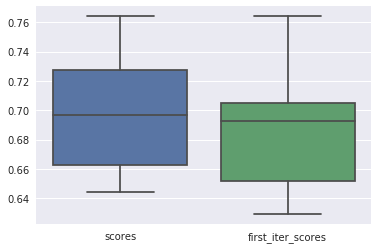

In [12]:
df = pd.DataFrame(data=list(zip(scores, first_iter_scores)),
                  columns=['scores','first_iter_scores'])
sns.boxplot(data=df)

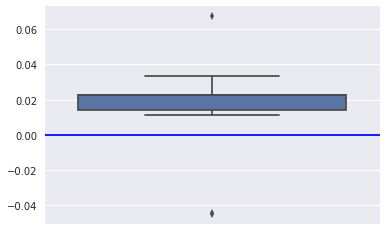

In [13]:
# look at boxplot
sns.boxplot(y=diff_scores)
plt.axhline(0, color='blue')

In [14]:
# How many times is the new model better?
print(f'New Model wins:  {(diff_scores > 0).sum()}')
print(f'New Model ties:  {(diff_scores == 0).sum()}')
print(f'New Model loses: {(diff_scores <= 0).sum()}')

New Model wins:  8
New Model ties:  0
New Model loses: 2


From the above boxplot and individual comparison of the scores, it appears the new model is slightly better.  The change we made was to impute the missing Age values by their mean value and make use of the Age value in the Logistic Regression Model.  It is reasonable that the model would improve with the addition of the Age variable.

### Model Summary
Model building steps only.

In [15]:
# read in all the labeled data
all_data = pd.read_csv('../data/train.csv')

# break up the dataframe into X and y
X = all_data.drop('Survived', axis=1)
y = all_data['Survived']

# As before, remove all non-numeric fields and PassengerId
drop_fields = ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'PassengerId']
X = X.drop(drop_fields, axis=1)

k_folds = 10
random_seed=5
crossvalidation = KFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

imputer = Imputer(strategy='mean')
classifier = make_pipeline(imputer, LogisticRegression())
scores = cross_val_score(classifier, X, y, cv=crossvalidation, 
                         scoring='accuracy', n_jobs=1)

# Use the mean score as the best estimate of model accuracy
print('Scores: ', np.round(scores,3))
print(f'Cross Validated Accuracy: {scores.mean() :.3f}')

Scores:  [0.644 0.719 0.719 0.764 0.652 0.663 0.663 0.764 0.73  0.674]
Cross Validated Accuracy: 0.699


In [16]:
# previous model
print(f'Previous Cross Validated Accuracy: {first_iter_scores.mean() :.3f}')

Previous Cross Validated Accuracy: 0.686


### Summary

In this iteration we:
* showed the right and wrong way to setup cross validation
* used Imputation as part of a Pipeline.  This improves the quality of the software as it concisely performs cross validation correctly
* added the Age variable to our model
* replaced missing Age values with the mean of the Age value
* slightly improved the model's accuracy from 68.6% to 69.9%